# Skin lesion Segmentation using ISIC dataset and U-Net architecture

In [1]:
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

#import albumentations as A

import os
import matplotlib.pyplot as plt

from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torchvision import transforms
#from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
from PIL import Image
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import random



TRAIN_IMG_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
TRAIN_MASK_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(os.path.join(TRAIN_IMG_PATH1, image_file) for image_file in os.listdir(TRAIN_IMG_PATH1) if image_file.endswith('.jpg'))
maskPaths = sorted(os.path.join(TRAIN_MASK_PATH1, mask_file) for mask_file in os.listdir(TRAIN_MASK_PATH1) if mask_file.endswith('_segmentation.png'))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
test_size=0.2, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


In [4]:
len(imagePaths)

2594

In [5]:
len(trainImages)

2075

In [6]:
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
os.mkdir(BASE_OUTPUT)
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "mask_model_1.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [7]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


Image Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg
Mask Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/ISIC_0000000_segmentation.png


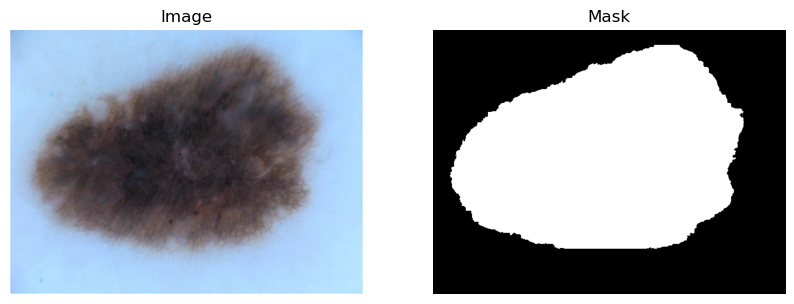

Image Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000001.jpg
Mask Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/ISIC_0000001_segmentation.png


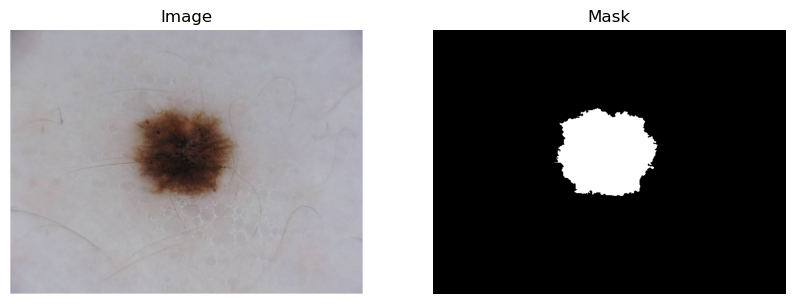

Image Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000003.jpg
Mask Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/ISIC_0000003_segmentation.png


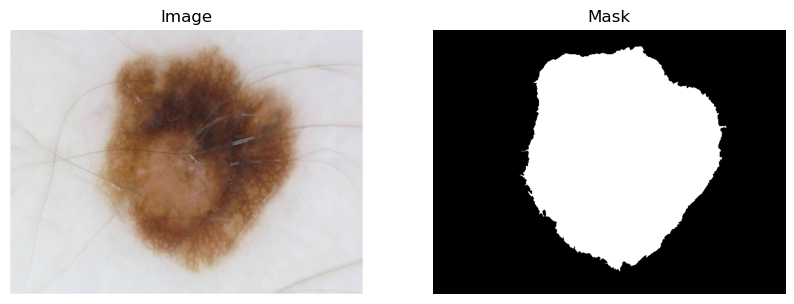

Image Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000004.jpg
Mask Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/ISIC_0000004_segmentation.png


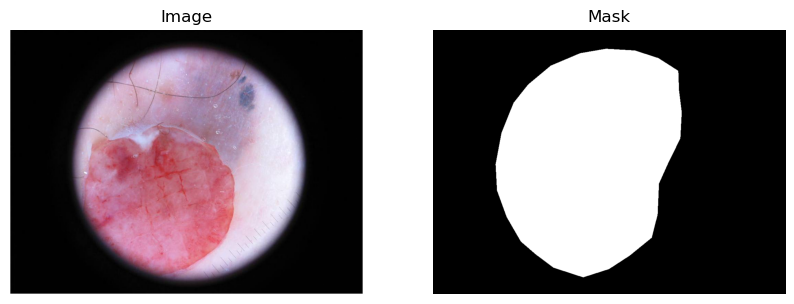

Image Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000006.jpg
Mask Path: /kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/ISIC_0000006_segmentation.png


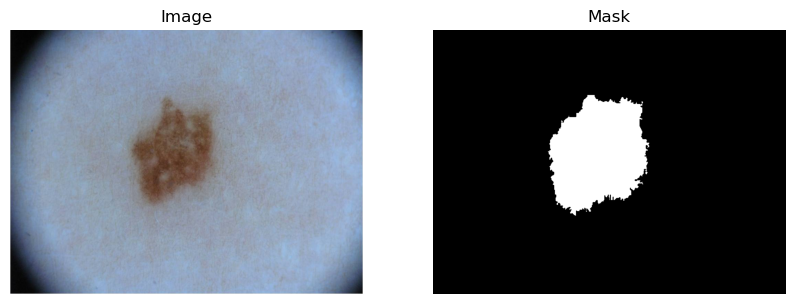

In [8]:
selected_image_files = imagePaths[:5]
selected_mask_files = maskPaths[:5]

# Display the selected images and masks
for img_file, mask_file in zip(selected_image_files, selected_mask_files):
    image_path = img_file
    mask_path = mask_file
    
    # Print the paths for debugging
    print(f"Image Path: {image_path}")
    print(f"Mask Path: {mask_path}")
    
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.show()




<font size=+2><b>2.Preparing Data</b> <br></font>

<font size=+1><b>2.1 Creating Custom Dataset</b> <br> </font>

In [9]:


# Constants

SIZE = 128
BATCH_SIZE = 8
NUM_WORKERS = 4
#PIN_MEMORY = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False




In [10]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        #self.transforms = transform
        self.transforms=[]
        if transform!=None:
            self.transforms.append(transform)
  

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        
        image_path = self.images_path[idx]
        img = Image.open(image_path).convert("RGB")
        #image = cv2.imread(image_path)
        #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
        
        
        #mask = cv2.imread(self.masks_path[idx], 0)
        mask = Image.open(self.masks_path[idx]).convert("L")
        #mask = torch.from_numpy(np.array(mask)).long()
        
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        # print(num_objs)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # Check if area is larger than a threshold
            A = abs((xmax-xmin) * (ymax-ymin)) 
            # print(A)
            if A < 5:
                print('Nr before deletion:', num_objs)
                obj_ids=np.delete(obj_ids, [i])
                # print('Area smaller than 5! Box coordinates:', [xmin, ymin, xmax, ymax])
                print('Nr after deletion:', len(obj_ids))
                continue
            # xmax=xmax+5 
            # ymax=ymax+5

            boxes.append([xmin, ymin, xmax, ymax])

        # print('nr boxes is equal to nr ids:', len(boxes)==len(obj_ids))
        num_objs = len(obj_ids)
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        for i in self.transforms:
            #img = i(img)
            #masks = i(masks)
            img, masks = i(img, masks)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        #target["labels"] = labels # Not sure if this is needed

        return img.double(), target
        


In [11]:
from PIL import Image
from torchvision.transforms import functional as F

In [12]:
from PIL import Image
from torchvision.transforms import functional as F
class MaskRCNNTransform():
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self,image, mask):
        image = F.resize(image, self.image_size)
        mask = F.resize(mask, self.image_size, interpolation = Image.NEAREST)
        image = F.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask

In [13]:
trainDS = ISICDataset(images_path=trainImages, masks_path=trainMasks, transform=MaskRCNNTransform((128,128)))#torchvision.transforms.ToTensor())
testDS = ISICDataset(images_path=testImages, masks_path=testMasks,transform=MaskRCNNTransform((128,128)))#torchvision.transforms.ToTensor())

In [14]:
# trainDS = ISICDataset(images_path=trainImages, masks_path=trainMasks,
#     transform=MaskRCNNTransform((128,128)))
# testDS = ISICDataset(images_path=testImages, masks_path=testMasks,
#     transform=MaskRCNNTransform((128,128)))
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")


[INFO] found 2075 examples in the training set...
[INFO] found 519 examples in the test set...


In [15]:
trainDS[0]

(tensor([[[0.6588, 0.6784, 0.6784,  ..., 0.6784, 0.6784, 0.6627],
          [0.6667, 0.6784, 0.6824,  ..., 0.6824, 0.6784, 0.6667],
          [0.6745, 0.6824, 0.6902,  ..., 0.6902, 0.6784, 0.6667],
          ...,
          [0.6549, 0.6627, 0.6745,  ..., 0.6784, 0.6706, 0.6588],
          [0.6471, 0.6549, 0.6706,  ..., 0.6706, 0.6627, 0.6549],
          [0.6471, 0.6549, 0.6667,  ..., 0.6667, 0.6588, 0.6510]],
 
         [[0.6510, 0.6627, 0.6706,  ..., 0.6549, 0.6549, 0.6510],
          [0.6549, 0.6627, 0.6745,  ..., 0.6588, 0.6549, 0.6549],
          [0.6588, 0.6706, 0.6824,  ..., 0.6706, 0.6588, 0.6549],
          ...,
          [0.6431, 0.6471, 0.6510,  ..., 0.6549, 0.6471, 0.6392],
          [0.6353, 0.6431, 0.6471,  ..., 0.6471, 0.6392, 0.6392],
          [0.6353, 0.6431, 0.6471,  ..., 0.6471, 0.6431, 0.6392]],
 
         [[0.5490, 0.5608, 0.5843,  ..., 0.5843, 0.5804, 0.5804],
          [0.5608, 0.5765, 0.5922,  ..., 0.5882, 0.5843, 0.5765],
          [0.5686, 0.5882, 0.6000,  ...,

In [16]:

# create the training and test data loaders
train_dataloader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())
test_dataloader = DataLoader(testDS, shuffle=False,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())
#train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [17]:
# Define data loader for training set
train_dataloader = torch.utils.data.DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True,collate_fn=lambda x:list(zip(*x)))
print(len(train_dataloader))
# Define data loader for training set
test_dataloader = torch.utils.data.DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=True,collate_fn=lambda x:list(zip(*x)))
print(len(test_dataloader))

260
65


In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

num_classes = 2
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model1=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=10e-4, weight_decay=0.0005)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 232MB/s]  


In [19]:
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [20]:
import numpy as np

def calculate_iou(box1, box2):
    intersection = np.logical_and(box1, box2)
    union = np.logical_or(box1, box2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    dice = (2 * np.sum(intersection)) / (np.sum(mask1) + np.sum(mask2))
    return dice

def calculate_jaccard(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    jaccard = np.sum(intersection) / (np.sum(mask1) + np.sum(mask2) - np.sum(intersection))
    return jaccard

def calculate_f1(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    precision = np.sum(intersection) / np.sum(mask1)
    recall = np.sum(intersection) / np.sum(mask2)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


In [ ]:

import time
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define your model, optimizer, dataloaders, etc.
# ...
startTime = time.time()
# Define the number of epochs
n_epochs = 5

# Initialize a dictionary to track training history
H = {"train_loss": [], "iou": [], "dice": [], "jaccard": [], "f1": []}

# Perform training loop for n epochs
model.train()
for epoch in tqdm(range(n_epochs), desc="Epochs"):
    totalTrainLoss = 0
    iou_list = []
    dice_list = []
    jaccard_list = []
    f1_list = []

    for images, targets in tqdm(train_dataloader, desc="Training Batches"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        model = model1.double()

        # Forward pass and calculate losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation and optimization step
        losses.backward()
        optimizer.step()

        totalTrainLoss += losses.item()
        
        
        #print(masks_pred)
        #print(loss_dict)
        # Compute metrics


        #masks_pred = loss_dict["loss_mask"].item()  # Assuming "loss_mask" is the key for mask predictions
        boxes_pred = loss_dict["loss_box_reg"].item()  # Assuming "loss_box_reg" is the key for box predictions
        #print("masks_pred shape before loop:", masks_pred)
        #print("boxes_pred shape before loop:", boxes_pred.shape)

#         for i, target in enumerate(targets):
#             masks_true = target["masks"].cpu().numpy()  # Convert to NumPy array
#             boxes_true = target["boxes"].cpu().numpy()  # Convert to NumPy array

#             iou = calculate_iou(masks_pred[i].cpu().numpy(), masks_true)
#             dice = calculate_dice(masks_pred[i].cpu().numpy(), masks_true)
#             jaccard = calculate_jaccard(masks_pred[i].cpu().numpy(), masks_true)
#             f1 = calculate_f1(masks_pred[i].cpu().numpy(), masks_true)


        for i, target in enumerate(targets):
            
            masks_pred = loss_dict["loss_mask"].item() 
            masks_true = target["masks"].cpu().numpy()  # Convert to NumPy array
            boxes_true = target["boxes"].cpu().numpy()  # Convert to NumPy array

            iou = calculate_iou(masks_pred, masks_true)
            dice = calculate_dice(masks_pred, masks_true)
            jaccard = calculate_jaccard(masks_pred, masks_true)
            f1 = calculate_f1(masks_pred, masks_true)

            iou_list.append(iou)
            dice_list.append(dice)
            jaccard_list.append(jaccard)
            f1_list.append(f1)

    avgTrainLoss = totalTrainLoss / len(train_dataloader)
    H["train_loss"].append(avgTrainLoss)
    
    # Calculate mean metrics
    mean_iou = np.mean(iou_list)
    mean_dice = np.mean(dice_list)
    mean_jaccard = np.mean(jaccard_list)
    mean_f1 = np.mean(f1_list)
    
    H["iou"].append(mean_iou)
    H["dice"].append(mean_dice)
    H["jaccard"].append(mean_jaccard)
    H["f1"].append(mean_f1)

    print(f"Epoch [{epoch+1}/{n_epochs}] - Train loss: {avgTrainLoss:.6f}")
    print(f"Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}, Mean Jaccard: {mean_jaccard:.4f}, Mean F1: {mean_f1:.4f}")

# Display the total time needed to perform the training
endTime = time.time()
print(f"Total time taken to train the model: {endTime - startTime:.2f}s")

Epochs:  20%|██        | 1/5 [2:44:54<10:59:39, 9894.89s/it]

Epoch [1/5] - Train loss: 196.340648
Mean IoU: 0.2114, Mean Dice: 2.0000, Mean Jaccard: 36774666198864.0000, Mean F1: 2.0000



Epochs:  60%|██████    | 3/5 [8:10:05<5:26:11, 9785.53s/it]

Epoch [3/5] - Train loss: 163.779962
Mean IoU: 0.2114, Mean Dice: 2.0000, Mean Jaccard: 60263473.2007, Mean F1: 2.0000



Epochs:  80%|████████  | 4/5 [10:52:02<2:42:38, 9758.35s/it]

Epoch [4/5] - Train loss: 163.676753
Mean IoU: 0.2114, Mean Dice: 2.0000, Mean Jaccard: 47572600.3761, Mean F1: 2.0000



Training Batches:   5%|▍         | 12/260 [07:22<2:28:17, 35.88s/it]

In [27]:
import time
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define your model, optimizer, dataloaders, etc.
# ...
startTime = time.time()
# Define the number of epochs
n_epochs = 5

# Initialize a dictionary to track training history
H = {"train_loss": [], "iou": [], "dice": [], "jaccard": [], "f1": []}

# Perform training loop for n epochs
model.train()
for epoch in tqdm(range(n_epochs), desc="Epochs"):
    totalTrainLoss = 0
    iou_list = []
    dice_list = []
    jaccard_list = []
    f1_list = []
    masks_pred_array = []

    for images, targets in tqdm(train_dataloader, desc="Training Batches"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        model = model1.double()

        # Forward pass and calculate losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation and optimization step
        losses.backward()
        optimizer.step()

        totalTrainLoss += losses.item()
        
        masks_pred = loss_dict["loss_mask"].detach() 
        
        print(masks_pred)
        
        masks_pred_array.extend(masks_pred.cpu().numpy())
    
        # Inside the loop where you calculate metrics
        for i, target in enumerate(targets):
            masks_true = target["masks"].cpu().numpy()  # Convert to NumPy array

            # Access the predicted masks using masks_pred_array
            masks_pred_i = masks_pred_array[i]

            iou = calculate_iou(masks_pred_i, masks_true)
            dice = calculate_dice(masks_pred_i, masks_true)
            jaccard = calculate_jaccard(masks_pred_i, masks_true)
            f1 = calculate_f1(masks_pred_i, masks_true)

            iou_list.append(iou)
            dice_list.append(dice)
            jaccard_list.append(jaccard)
            f1_list.append(f1)

    avgTrainLoss = totalTrainLoss / len(train_dataloader)
    H["train_loss"].append(avgTrainLoss)
    
    # Calculate mean metrics
    mean_iou = np.mean(iou_list)
    mean_dice = np.mean(dice_list)
    mean_jaccard = np.mean(jaccard_list)
    mean_f1 = np.mean(f1_list)
    
    H["iou"].append(mean_iou)
    H["dice"].append(mean_dice)
    H["jaccard"].append(mean_jaccard)
    H["f1"].append(mean_f1)

    print(f"Epoch [{epoch+1}/{n_epochs}] - Train loss: {avgTrainLoss:.6f}")
    print(f"Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}, Mean Jaccard: {mean_jaccard:.4f}, Mean F1: {mean_f1:.4f}")

# Display the total time needed to perform the training
endTime = time.time()
print(f"Total time taken to train the model: {endTime - startTime:.2f}s")


Epochs:   0%|          | 0/5 [00:36<?, ?it/s]

tensor(4.8767e-10, device='cuda:0', dtype=torch.float64)


TypeError: iteration over a 0-d array

We will now plot some predictions

In [ ]:
THRESHOLD = 0.5

def make_predictions(model, imagePath, gtMask):
    # Set model to evaluation mode
    model.eval()
    
    # Turn off gradient tracking
    with torch.no_grad():
        # Load and preprocess the image
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        image = cv2.resize(image, (SIZE, SIZE))
        orig = image.copy()
        
        # Prepare the input tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE, dtype=torch.double)  # Convert to double
        
        # Convert model parameters to double precision
        model = model.double()
        
        # Make the prediction
        pred_dict = model(image)
        predMask_list = pred_dict[0]['masks']  # Assuming 'masks' is the key for masks
        
        # Apply sigmoid to each mask and convert to numpy
        predMask_list = [torch.sigmoid(mask) for mask in predMask_list]
        predMask_list = [mask.cpu().numpy() for mask in predMask_list]
        
        # Filter and prepare the masks for visualization
        predMask_list = [(mask > THRESHOLD) * 255 for mask in predMask_list]
        predMask_list = [mask.astype(np.uint8) for mask in predMask_list]
        
        # Prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask_list)
        
        


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

In [ ]:
torch.save(model, MODEL_PATH)
Mask_rcnn = torch.load(MODEL_PATH, map_location=DEVICE).to(DEVICE)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
Mask_rcnn = torch.load(MODEL_PATH).to(DEVICE)


In [ ]:
loaded_model = torch.load(MODEL_PATH, map_location=DEVICE)
for param in loaded_model.parameters():
    param.data = param.data.to(DEVICE, dtype=torch.float32)
Mask_rcnn = loaded_model.to(DEVICE)


In [ ]:

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
Mask_rcnn = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    groundTruthPath = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"
    make_predictions(Mask_rcnn,maskPaths, path)

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Constants
SIZE = 128
BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your dataset class, transforms, and dataloaders
# ... (ISICDataset, MaskRCNNTransform, trainDS, testDS, train_dataloader, test_dataloader)

# Load an instance segmentation model pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2  # Change this to the number of classes in your task

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# Replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move the model to the device
model = model.to(DEVICE)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# Training loop
n_epochs = 2
H = {"train_loss": []}

model.train()
for epoch in range(n_epochs):
    total_train_loss = 0
    
    for images, targets in train_dataloader:
        images = [image.to(DEVICE) for image in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    H["train_loss"].append(avg_train_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs}] - Train loss: {avg_train_loss:.6f}")

# Make predictions and visualize the results
THRESHOLD = 0.5

def make_predictions(model, imagePath, gtMask, threshold=THRESHOLD):
    model.eval()
    
    with torch.no_grad():
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        image = cv2.resize(image, (SIZE, SIZE))
        orig = image.copy()
        
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE, dtype=torch.double)
        
        model = model.double()
        
        pred_dict = model(image)
        predMask_list = pred_dict[0]['masks']
        
        predMask_list = [torch.sigmoid(mask) for mask in predMask_list]
        predMask_list = [mask.cpu().numpy() for mask in predMask_list]
        
        predMask_list = [(mask > threshold) * 255 for mask in predMask_list]
        predMask_list = [mask.astype(np.uint8) for mask in predMask_list]
        
        prepare_plot(orig, gtMask, predMask_list)

def prepare_plot(origImage, origMask, predMask):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    figure.tight_layout()
    plt.show()

# Load the image paths from your testing file and randomly select 10 image paths
TEST_PATHS = "path_to_test_image_list.txt"
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# Load the model from disk and move it to the current device
MODEL_PATH = "path_to_saved_model.pt"
Mask_rcnn = torch.load(MODEL_PATH, map_location=DEVICE).to(DEVICE)

# Iterate over the randomly selected test image paths
for path in imagePaths:
    # Provide the correct path to the ground truth mask
    groundTruthPath = "path_to_ground_truth_mask.png"
    # Make predictions and visualize the results
    make_predictions(Mask_rcnn, path, groundTruthPath)
